In [2]:
import nlp_utils
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageDraw, ImageFont
from nlp_utils import add_text_to_image


In [3]:

df_celeba = nlp_utils.get_celeba_data_df(limit=None)
attr_names = df_celeba.columns[2:]
print('attribute_names', attr_names)
df_celeba.head()

attribute_names Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')


,image_path,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,/home/dcor/roeyron/interpretability_multi_hop/...,000001.jpg,False,True,True,False,False,False,False,False,...,False,True,True,False,True,False,True,False,False,True
1,/home/dcor/roeyron/interpretability_multi_hop/...,000002.jpg,False,False,False,True,False,False,False,True,...,False,True,False,False,False,False,False,False,False,True
2,/home/dcor/roeyron/interpretability_multi_hop/...,000003.jpg,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
3,/home/dcor/roeyron/interpretability_multi_hop/...,000004.jpg,False,False,True,False,False,False,False,False,...,False,False,True,False,True,False,True,True,False,True
4,/home/dcor/roeyron/interpretability_multi_hop/...,000005.jpg,False,True,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True


In [4]:
possible_face_ares = ['hair', 'lips', 'nose', 'eyes', 'facial hair', 'eyebrows', 'chin', 'face structure', 'cheeks', 'neck']

prompts_dictionary = {
    "5_o_Clock_Shadow": "facial hair",
    "Arched_Eyebrows": "eyebrows",
    "Attractive": None,
    "Bags_Under_Eyes": "eyes",
    "Bald": "hair",
    "Bangs": "hair",
    "Big_Lips": "lips",
    "Big_Nose": "nose",
    "Black_Hair": "hair",
    "Blond_Hair": "hair",
    "Blurry": None,
    "Brown_Hair": "hair",
    "Bushy_Eyebrows": "eyebrows",
    "Chubby": None,
    "Double_Chin": "chin",
    "Eyeglasses": "eyes",
    "Goatee": "facial hair",
    "Gray_Hair": "hair",
    "Heavy_Makeup": None,
    "High_Cheekbones": 'cheeks',
    "Male": None,
    "Mouth_Slightly_Open": "lips",
    "Mustache": "facial hair",
    "Narrow_Eyes": "eyes",
    "No_Beard": None, #  "facial hair",
    "Oval_Face": 'face structure',
    "Pale_Skin": None,
    "Pointy_Nose": 'nose',
    "Receding_Hairline": "hair",
    "Rosy_Cheeks": "cheeks",
    "Sideburns": "hair",
    "Smiling": "lips",
    "Straight_Hair": "hair",
    "Wavy_Hair": "hair",
    "Wearing_Earrings": None, # "ears",
    "Wearing_Hat": "hair",
    "Wearing_Lipstick": "lips",
    "Wearing_Necklace": "neck",
    "Wearing_Necktie": "neck",
    "Young": None,
}

Attributre: Bald
Prompt (hair): Describe the hair of the person in the image


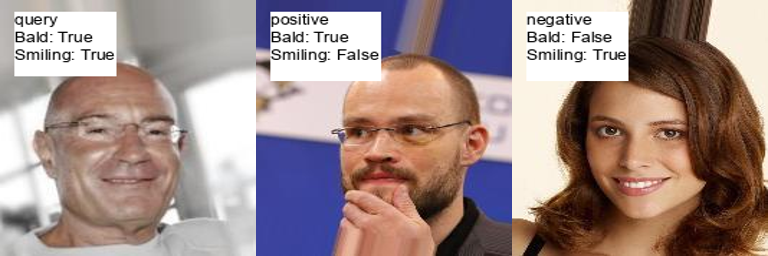

In [22]:
possible_face_ares = ['hair', 'lips', 'age']


attr_names = [k for k, v in prompts_dictionary.items() if v]
interest_attr = np.random.choice(attr_names)
 
# interest_attr = 'Young'  # attribute to focus on

query_candidates = df_celeba[interest_attr] & pd.Series(df_celeba[attr_names].values.sum(axis=1) > 1)  # we want to have at least 2 True attributes for the query

query_ind = np.random.choice(np.where(query_candidates.values)[0])  # choose a random query index
other_attr = np.random.choice([a for a in attr_names if a != interest_attr and df_celeba.iloc[query_ind][a]])  # choose an attribute different from interest_attr that the query has

negative_candidates = ~df_celeba[interest_attr] & df_celeba[other_attr]
negative_ind = np.random.choice(np.where(negative_candidates.values)[0])
positive_candidates = df_celeba[interest_attr] & ~df_celeba[other_attr]
positive_ind = np.random.choice(np.where(positive_candidates.values)[0])

ids = [query_ind, positive_ind, negative_ind]
texts = []
for name, i in zip(['query', 'positive', 'negative'], ids):
    texts.append(f'{name}\n{interest_attr}: {df_celeba.iloc[i][interest_attr]}\n{other_attr}: {df_celeba.iloc[i][other_attr]}')

image_paths = [df_celeba.image_path.iloc[i] for i in ids]
images = [Image.open(p) for p in image_paths]
# texts = [f'query\n{interest_attr}-y\n{other_attr}-y', f'positive\n{interest_attr}-y\n', f'negative\n{other_attr}']
images = [add_text_to_image(image, text, 12) for image, text in zip(images, texts)]
print('Attributre:', interest_attr)
prompt_id = prompts_dictionary[interest_attr]
print(f'Prompt ({prompt_id}): Describe the {prompts_dictionary[interest_attr]} of the person in the image')
Image.fromarray(np.concatenate([img.resize((256, 256)) for img in images], axis=1))

